In [1]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from netCDF4 import Dataset,num2date
from eofs.standard import Eof
from sklearn.cluster import KMeans
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.path as mpath
from scipy import stats,signal
from scipy.ndimage import uniform_filter1d
import pandas as pd

In [2]:
def make_boundary_path(minlon,maxlon,minlat,maxlat,n=50):
    '''
    return a matplotlib Path whose points are a lon-lat box given by
    the input parameters
    '''
    boundary_path = []
    #North (E->W)
    edge = [np.linspace(minlon,maxlon,n), np.full(n,maxlat)]
    boundary_path += [[i,j] for i,j in zip(*edge)]
    #West (N->S)
    edge = [np.full(n,maxlon),np.linspace(maxlat,minlat,n)]
    boundary_path += [[i,j] for i,j in zip(*edge)]
    #South (W->E)
    edge = [np.linspace(maxlon,minlon,n), np.full(n,minlat)]
    boundary_path += [[i,j] for i,j in zip(*edge)]
    #East (S->N)
    edge = [np.full(n,minlon),np.linspace(minlat,maxlat,n)]
    boundary_path += [[i,j] for i,j in zip(*edge)]
    boundary_path = mpath.Path(boundary_path)
    return boundary_path

In [3]:
def get_era(year1,year2,lev_anl,lat_south,lat_north,lon_west,lon_east,climo_smooth_days):
    """
    year1 = start year (inclusive)
    year2 = end year (inclusive)
    lev_anl = pressure level (hPa)
    lat_south, lat_north = latitude boundaries (inclusive) in degrees north
    lon_west, lon_east = longitude boundaries (inclusive) in degrees east
    note this function doesn't work for data straddling GM!
    climo_smooth_days = number of days to use to smooth climatology
    """
    g=9.80665
    
    # loop through these years
    years = np.arange(year1,year2+1,1)
    # directory where ERA stored
    era_dir = " " 

    # Open first file to get grid -- assumes grid is consistent (not an unreasonable assumption)
    f1 = Dataset(era_dir+"era5_"+str(year1)+"_plevs.nc",'r')
    lats = f1.variables['latitude'][:]
    lons = f1.variables['longitude'][:]
    levs = f1.variables['level'][:]
    levidx = np.where(levs==lev_anl)[0][0]
    tcal = f1.variables['time'].calendar
    tunit = f1.variables['time'].units
    latcut = np.where((lats>=lat_south)&(lats<=lat_north))[0]
    # the lon grid is 0-360
    loncut = np.where((lons>=lon_west)&(lons<=lon_east))[0]
    f1.close()

    lats=lats[latcut]
    lons=lons[loncut]
    
    # arrays to store output from loops
    z_store = np.full((len(years),365,len(latcut),len(loncut)),np.nan)
    time_store = np.zeros((len(years),365),dtype=object)

    for y, year in enumerate(years):
        print(year)
        f = Dataset(era_dir+"era5_"+str(year)+"_plevs.nc",'r')
        ## for years where there is the prelim and the final version (i.e. expver dimension in ERA5)
        if len(f.variables['z'].shape)==5:
            z1 = f.variables['z'][:,0,levidx,latcut,loncut]/g
            z2 = f.variables['z'][:,1,levidx,latcut,loncut]/g
            idx1 = np.squeeze(np.where(z1[:,0,0].mask==False))
            idx2 = np.squeeze(np.where(z2[:,0,0].mask==False))
            z1_data = z1[idx1]; z2_data = z2[idx2]
            z = np.concatenate((z1_data,z2_data),axis=0)
        else:
            z = f.variables['z'][:,levidx,latcut,loncut]/g

        time = num2date(f.variables['time'][:],tunit,tcal)
        f.close()

        # delete 29 Feb if present for the sake of convenience
        if len(time)==366:
            leap_idx = np.where(time==datetime(year,2,29))[0][0]
            z = np.delete(z,leap_idx,axis=0)
            time=np.delete(time,leap_idx,axis=0)
            
        ## workaround for incomplete years
        if len(time)<365:
            incomplete_year=True
            z_store[y,:len(z)]=z
            time_store[y,:len(time)]=time
        else:
            incomplete_year=False
            z_store[y]=z
            time_store[y]=time

    # calculate daily climatology and anomalies
    z_climo = np.nanmean(z_store,axis=0)
    # smooth with specified window
    z_climo_smooth = uniform_filter1d(z_climo,size=climo_smooth_days,axis=0,mode='wrap')
    z_anom = z_store-z_climo_smooth

    # flatten time dimension
    time_store=time_store.flatten()
    z_anom = np.reshape(z_anom,(z_anom.shape[0]*z_anom.shape[1],z_anom.shape[-2],z_anom.shape[-1]))

    if incomplete_year==True:
        idx_nan = np.where(np.isnan(z_anom[:,0,0])==True)[0][0]
    else:
        idx_nan=len(z_anom)

    return z_anom[:idx_nan],time_store[:idx_nan],z_climo,z_climo_smooth,lats,lons

# General parameters

In [4]:
year1=1979 ## start year, inclusive
year2=2023 ## end year, inclusive
climo_smooth_days=1 ## number of days to use in daily climatology smoothing, use 1 for a basic climo
subset_months=[12,1,2,3] ## months to use data
detrend = True ## remove trend in area-average z500
n_eof = 12 # number of EOFs to retain, retaining 3 is a minimum, but 12 is typical
ncluster = 4 ## number of clusters to produce

# Data preparation

In [5]:
z_anoms,regtime,z_climo,z_climo_smooth,lats,lons = get_era(year1,year2,500,20,80,180,330,climo_smooth_days)

1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023


In [6]:
## extract just winter days
subset_idx = np.array([t.month in subset_months for t in regtime])
z_anoms=z_anoms[subset_idx]
regtime=regtime[subset_idx]

In [7]:
## detrend anomalies
if detrend==True:
    # subtract trend in area-average z500
    t=np.arange(len(regtime))
    avg_z500 = np.average(np.mean(z_anoms,axis=-1),axis=-1,weights=np.cos(np.radians(lats)))
    avg_z500_trend = stats.linregress(t,avg_z500)
    print(avg_z500_trend)
    
    trendline=(avg_z500_trend[0]*t)+avg_z500_trend[1]
    z_anoms_detrend=z_anoms-trendline[:,np.newaxis,np.newaxis]
    z_anoms=z_anoms_detrend

LinregressResult(slope=0.005628018670609901, intercept=-15.319466821400143, rvalue=0.39196494593636344, pvalue=1.9340282961696132e-199, stderr=0.00017904722374285445, intercept_stderr=0.5627882522698692)


# EOF analysis

In [8]:
##Square-root cosine weights for EOF analysis
weights = np.sqrt(np.cos(np.radians(lats)))[:,np.newaxis]

In [9]:
## EOF analysis
print("Performing EOF analysis...")
solver = Eof(z_anoms,weights=weights)
pcs = solver.pcs(npcs=n_eof,pcscaling=0)
print("EOF analysis completed!")

Performing EOF analysis...
EOF analysis completed!


# Clustering

In [10]:
# Clustering!
print ("Begin K-means clustering...")
print (ncluster, "clusters")
## The random state parameter allows for reproducibility
kmeans = KMeans(n_clusters=ncluster, n_init=500, max_iter=500,random_state=42).fit(pcs)
print("Clustering completed!")

Begin K-means clustering...
4 clusters
Clustering completed!


In [11]:
model_clust = kmeans.labels_ ## regime of each day
centroids = kmeans.cluster_centers_

# Sort regimes

In [12]:
# Specify the regime ID by its occupation frequency
# Calculate what percentage of days fall into each type
ratios = np.full(ncluster,np.nan)
for i in range(ncluster):
	ratios[i] = 100*(np.sum(model_clust==i)/len(model_clust))

print(ratios)

ratios_sorted = np.sort(ratios)[::-1]
# indices to sort array
idx_ratio_sort = np.argsort(ratios)[::-1]
print(idx_ratio_sort)

[19.02662994 31.8640955  24.55463728 24.55463728]
[1 3 2 0]


In [13]:
# make new array to input the new identifiers
new_clust = np.full(np.shape(model_clust),np.nan)
new_centroids = np.full(np.shape(centroids),np.nan)

for i in range(ncluster):

    new_id = int(np.where(idx_ratio_sort==i)[0][0])
    new_clust[np.where(model_clust==i)[0]]=new_id
    new_centroids[new_id]=centroids[i]

model_clust=new_clust
centroids=new_centroids

In [14]:
# regime names
# these might not fit if the regime frequencies shift
regnames = ['Pacific Trough (PT)', 'Arctic Low (ArL)', 'Alaskan Ridge (AKR)', 'Arctic High (ArH)']
regcols = ['purple','cornflowerblue','orange','tomato']
markers=['D','X','s','o']

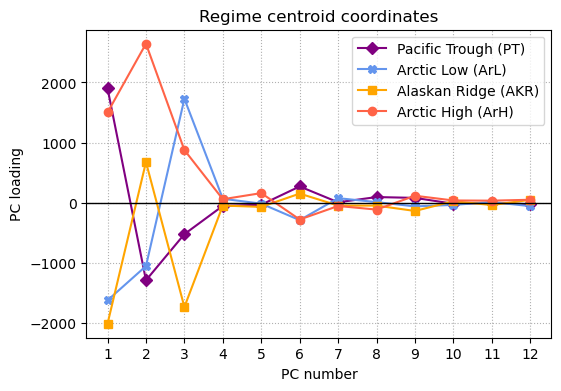

In [15]:
## plot the centroids
## this demonstrates that only the leading three PCs are important
x = np.arange(1,n_eof+1,1)
plt.figure(figsize=(6,4))
for r in range(ncluster):
    plt.plot(x,centroids[r],color=regcols[r],label=regnames[r],marker=markers[r])
plt.axhline(0,color='k',lw=1)
plt.grid(ls=':')
plt.xticks(x,x)
plt.legend(loc='upper right')
plt.xlabel("PC number")
plt.ylabel("PC loading")
plt.title("Regime centroid coordinates")
plt.show()

In [16]:
time_strs = [str(t.year)+"-"+str(t.month).zfill(2)+"-"+str(t.day).zfill(2) for t in regtime]
cluster_df = pd.DataFrame(model_clust, index=time_strs,dtype='int')
# Save series output
#cluster_df.to_csv('era5_djfm_namer_regimes_'+str(year1)+'_'+str(year2)+'.txt', sep=' ', index=True,header=False)

# Composite

In [17]:
## Plot the composite
regime_composite = np.full((ncluster,z_anoms.shape[1],z_anoms.shape[2]),np.nan)
for r in range(ncluster):
	subset = np.where(model_clust==r)[0]
	regime_composite[r] = np.mean(z_anoms[subset],axis=0)

Cluster Z500 map figure...


/burg/apam/users/shl2180/.conda/envs/myconda/lib/python3.9/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/burg/apam/users/shl2180/.conda/envs/myconda/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


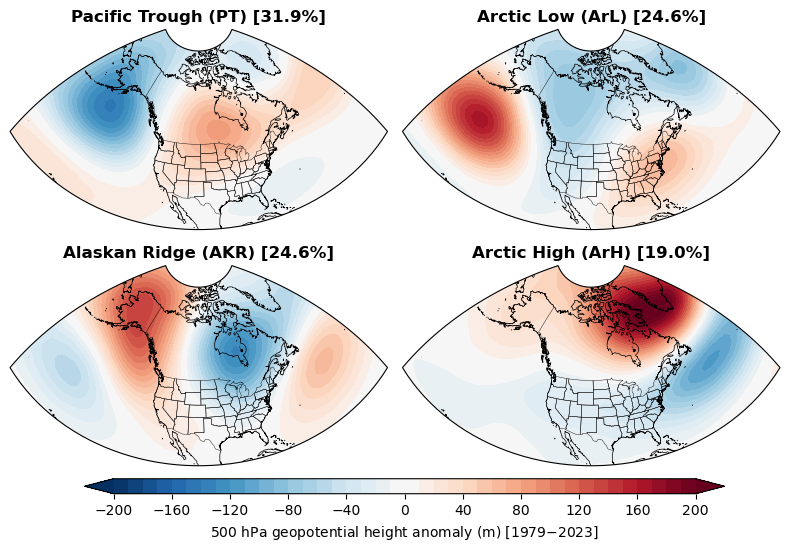

In [18]:
print("Cluster Z500 map figure...")
clevs = np.concatenate((np.arange(-200,0,10),np.arange(10,210,10)))
cticks = np.arange(-200,220,40)

## specify extent of boundary
extent =[np.min(lons),np.max(lons),np.min(lats),np.max(lats)]

fig,axs = plt.subplots(2,2,figsize=(8,5),tight_layout=True,subplot_kw={'projection': ccrs.LambertAzimuthalEqualArea(central_longitude=np.median(lons), central_latitude=np.median(lats))})
for a, ax in enumerate(axs.reshape(-1)):
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    boundary = make_boundary_path(*extent)
    ax.set_boundary(boundary, transform=ccrs.PlateCarree())
    cf = ax.contourf(lons,lats,regime_composite[a],cmap='RdBu_r',extend='both',levels=clevs,transform=ccrs.PlateCarree())
    ax.coastlines(color='k',resolution='50m',linewidth=0.5)
    ax.add_feature(cfeature.STATES, zorder=1, linewidth=0.3, edgecolor='k')
    ax.set_title(str(regnames[a])+" ["+str("%0.1f" % ratios_sorted[a])+"%]",weight="bold")
    
cb_ax = fig.add_axes([0.112, 0, 0.8, 0.03])
cbar = fig.colorbar(cf, cax=cb_ax,orientation="horizontal",ticks=cticks,extend="both",spacing='proportional')
cbar.set_label("500 hPa geopotential height anomaly (m) ["+str(year1)+"$-$"+str(year2)+"]")

#plt.savefig("djfm_american_regimes_"+str(year1)+"_"+str(year2)+".png",dpi=600,bbox_inches='tight')

# Weather Regime Index

In [21]:
## Variation on Michel and Riviere 2011 JAS
## Project each day onto composite regime map
weights_iwr=np.cos(np.radians(lats))
projection = np.full((ncluster,len(z_anoms)),np.nan)
for r in range(ncluster):
	for d in range(len(z_anoms)):
		projection[r,d]=np.dot((z_anoms[d]*weights_iwr[:,np.newaxis]).flatten(),regime_composite[r].flatten())

## Calculate mean projection
mean_proj = np.mean(projection,axis=1)
## Calculate std dev of projection
std_dev_proj = np.std(projection,axis=1)
## Compute normalized weather regime projection IWR
IWR = (projection-mean_proj[:,np.newaxis])/std_dev_proj[:,np.newaxis]

In [22]:
def IWR_plot(date_start,date_end):

    ## time array for plotting
    time_plot = regtime[date_start:date_end+1]
    ## assigned regimes by min euclidean distance
    assigned_regimes = model_clust[date_start:date_end+1]

    ## figure
    fig, ax = plt.subplots(figsize=(10,6),tight_layout=True)
    for r in range(ncluster):
    	plt.plot(time_plot,IWR[r,date_start:date_end+1].T,color=regcols[r])
    	plt.plot(time_plot,np.ma.masked_less(IWR[r,date_start:date_end+1].T,1),marker=markers[r],color=regcols[r],label=regnames[r])
        
    plt.legend(loc='lower center',ncol=ncluster)
    plt.grid(linestyle=':')
    plt.axhline(0,color='k',linewidth=1)
    ticklab_subset = np.array([t.day in [1,15] for t in time_plot])
    xticklabs = np.array([datetime.strftime(t,"%-d %b %Y") for t in time_plot[ticklab_subset]])
    plt.ylim(-4,4.8)
    plt.ylabel("Weather regime index ($\sigma$)",weight="bold")
    plt.xticks(time_plot[ticklab_subset],xticklabs,rotation=90,fontsize=9)
    plt.xlim(time_plot[0],time_plot[-1])
    plt.axhline(4,color='k')
    plt.title("DJFM North American Weather Regimes "+str(regtime[date_start].year)+"$-$"+str(regtime[date_start].year+1),weight="bold")
    for d in range(len(assigned_regimes)):
    	plt.scatter(time_plot[d],4.2+0.15*assigned_regimes[d],marker=markers[int(assigned_regimes[d])],color=regcols[int(assigned_regimes[d])])
    return fig

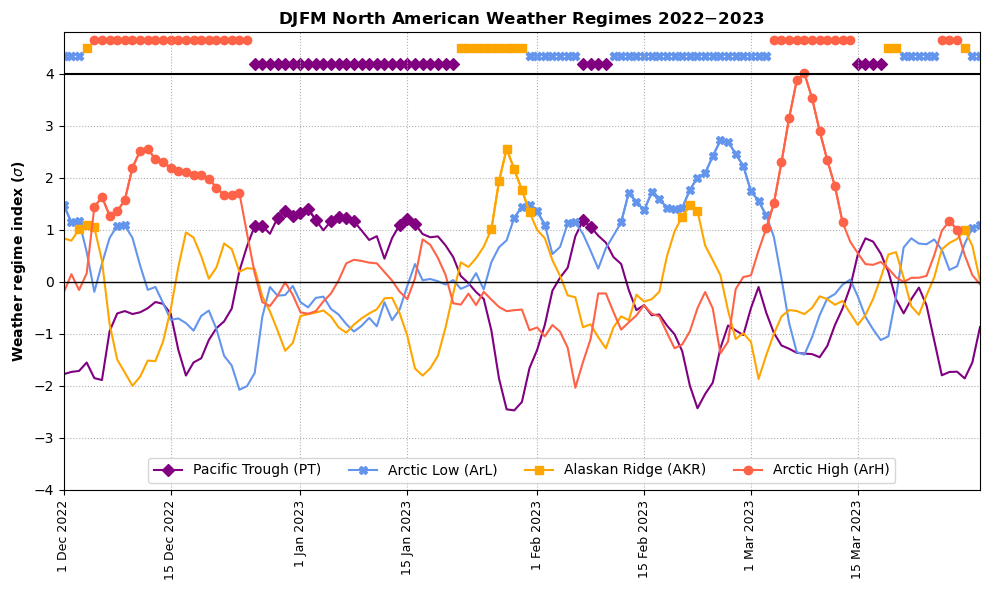

In [23]:
year=2022
regtime = np.array([datetime(t.year,t.month,t.day) for t in regtime])
date_start = np.where(regtime==datetime(year,12,1))[0][0]
date_end = np.where(regtime==datetime(year+1,3,31))[0][0]
fig = IWR_plot(date_start,date_end)